The strategy that we are going to use to detect connection from DDOS attacks is to use a clustering technique to group connections. In DDOS attacks connections are all the same so I expect to find them in clusters well defined and a bit separate from normal connections.

In [1]:
%load_ext autoreload

In [50]:
%autoreload
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from sklearn import set_config

from intrusion_detection.load_input_data import load_df
from intrusion_detection.preprocessing.preprocessing import remove_dot_from_attack_type_classes
from intrusion_detection.target_definition import define_target
from intrusion_detection.preprocessing.pipeline import get_preprocessing_pipeline
from intrusion_detection.feature_selection.pipeline import get_feature_selection_pipeline
set_config(display="diagram")

In [28]:
df = load_df(
    file_path="../../../data/kddcup.data_10_percent",
    header_file="../../../data/kddcup.names"
)
df = remove_dot_from_attack_type_classes(df)

### Features selection

For this exercise, I will use feature selection to drop highly correlated features and quasi-constant features. The complete pipeline that I am going to use for this model is below:

In [53]:
from sklearn.pipeline import Pipeline
numerical_columns = df.select_dtypes(exclude=object).columns.to_list()

df_target = define_target(df)
preprocessing_pipeline = get_preprocessing_pipeline()
feature_selection_pipeline = get_feature_selection_pipeline(numerical_columns)
pre_model_pipeline = Pipeline(
    [*preprocessing_pipeline.steps, *feature_selection_pipeline.steps]
)
pre_model_pipeline

Pipeline(steps=[('drop_target', DropFeatures(features_to_drop=['attack_type'])),
                ('outlier_removal',
                 Winsorizer(add_indicators=True, capping_method='quantiles',
                            fold=0.01, variables=['src_bytes', 'dst_bytes'])),
                ('frequency_encoder',
                 KeepInputFeaturesWrapper(rename_suffix='_freq',
                                          wrapped_transformer=CountFrequencyEncoder(encoding_method='frequency',
                                                                                    unseen='...
                                                   'logged_in',
                                                   'num_compromised',
                                                   'root_shell', 'su_attempted',
                                                   'num_root',
                                                   'num_file_creations',
                                                   'num_shells',
                                                   'num_access_files',
                                                   'num_outbound_cmds',
                                                   'is_host_login',
                                                   'is_guest_login', 'count',
                                                   'srv_count', 'serror_rate',
                                                   'srv_serror_rate',
                                                   'rerror_rate',
                                                   'srv_rerror_rate',
                                                   'same_srv_rate',
                                                   'diff_srv_rate',
                                                   'srv_diff_host_rate',
                                                   'dst_host_count',
                                                   'dst_host_srv_count', ...]))])

In [54]:
preprocessed_df = pre_model_pipeline.fit_transform(df)

### Determine the optimal number of clusters

In order to determine the optimal number of clusters, I will use the elbow technique.
To save time, I have preprocessed the entire dataset prior to use clustering. I am aware that this can introduce potential leakages, but I think that at this stage, considering the problem we are trying to solve here, it should not be a too big of a deal.

In [30]:
from sklearn.cluster import KMeans
from tqdm import tqdm

def plot_elbow_graph(df, max_k):
    distortions = []
    k_range = range(1, max_k)
    for k in tqdm(k_range):
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(df)
        distortions.append(kmeanModel.inertia_)
    plt.figure(figsize=(16,8))
    plt.plot(k_range, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

100%|██████████| 9/9 [00:13<00:00,  1.49s/it]


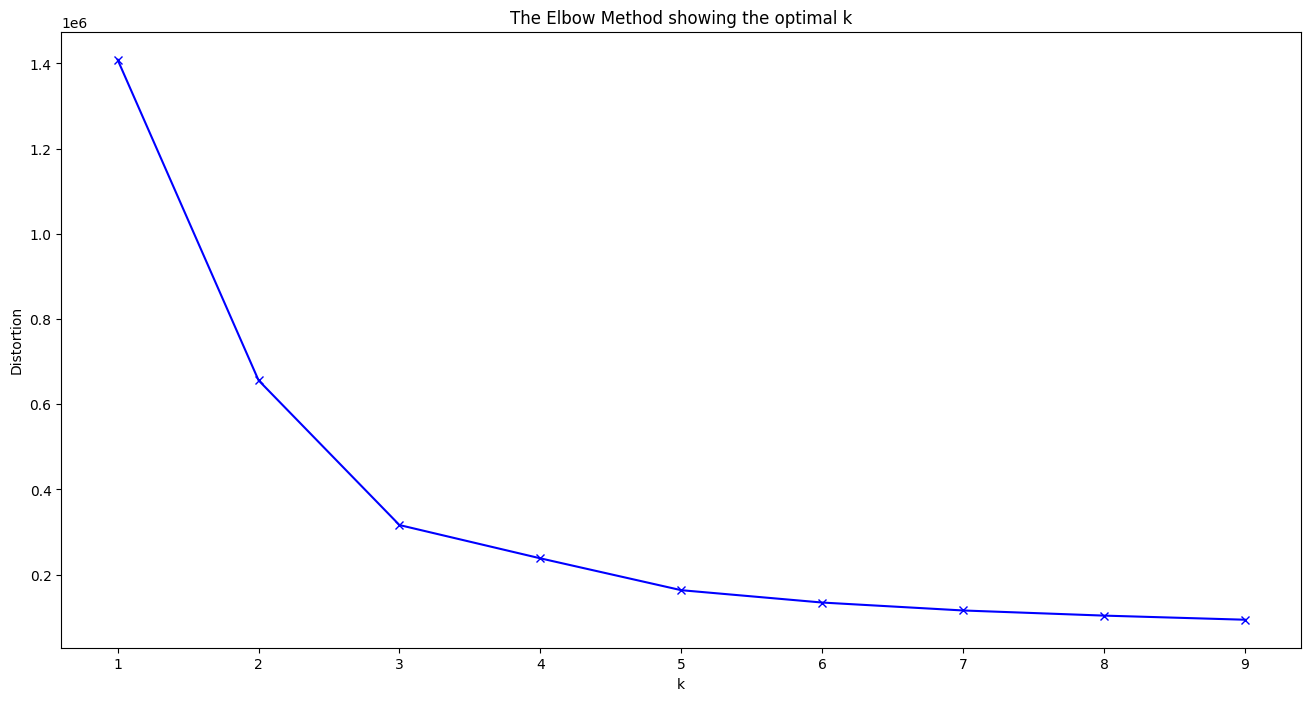

In [32]:
plot_elbow_graph(preprocessed_df, 10)

From the elbow graph it would make sense to use either 3 or 5 clusters. We know that the classes here are 3 - normal, smurf and neptune, so it would make sense to use 3 clusters.

## Determine which cluster to consider as Normal

In [58]:
clustering_preds = KMeans(n_clusters=3).fit_predict(preprocessed_df)
cluster_counts = pd.Series(clustering_preds).value_counts().to_frame()
cluster_counts

,0
0,281400
1,109872
2,102749


The table above shows the number of instances for each cluster.

Looking at the table above, we see that the numbers make sense and that they match with what we found in the target analysis. Possible candidates for our normal class are clusters # 1 and # 2. To systematically determine the normal cluster we could calculate the silhouette score for each cluster and take the cluster with the lowest silhouette score as our normal class. This logic comes from the intuition that connections from ddos attacks are all similar and thus they are well clustered, whether other connections will be more spread apart.

In [59]:
from sklearn.metrics import silhouette_samples

# I use a sample to calculate silhouette_scores because calculating it on the entire
# dataset would be computationally expensive
sample_size = 10000
sampled_index = np.random.choice(preprocessed_df.index, sample_size, replace=False)
silhouette_scores = silhouette_samples(
    preprocessed_df.iloc[sampled_index], clustering_preds[sampled_index]
)
means_lst = []
for label in range(3):
    means_lst.append(silhouette_scores[clustering_preds[sampled_index] == label].mean())

cluster_counts["approx_silhouette_score"] = means_lst

cluster_counts

,0,approx_silhouette_score
0,281400,0.971497
1,109872,0.685054
2,102749,0.378259


## DDOS Detector Pipeline

Following the logic above, cluster #2 is probably our normal class because it has the lowest silhouette score.

This logic above seems to work and it makes sense to me. I have wrapped it inside the class
`intrusion_detection.modelling.ddos_detector.DDOSDetector`. I will now use it to make inference and to get the final estimation.

In [38]:
from intrusion_detection.modelling.ddos_detector import DDOSDetector

In [60]:
ddos_detector_pipeline = Pipeline(
    [*preprocessing_pipeline.steps, *feature_selection_pipeline.steps, ("model", DDOSDetector())]
)
ddos_detector_pipeline

Pipeline(steps=[('drop_target', DropFeatures(features_to_drop=['attack_type'])),
                ('outlier_removal',
                 Winsorizer(add_indicators=True, capping_method='quantiles',
                            fold=0.01, variables=['src_bytes', 'dst_bytes'])),
                ('frequency_encoder',
                 KeepInputFeaturesWrapper(rename_suffix='_freq',
                                          wrapped_transformer=CountFrequencyEncoder(encoding_method='frequency',
                                                                                    unseen='...
                                                   'root_shell', 'su_attempted',
                                                   'num_root',
                                                   'num_file_creations',
                                                   'num_shells',
                                                   'num_access_files',
                                                   'num_outbound_cmds',
                                                   'is_host_login',
                                                   'is_guest_login', 'count',
                                                   'srv_count', 'serror_rate',
                                                   'srv_serror_rate',
                                                   'rerror_rate',
                                                   'srv_rerror_rate',
                                                   'same_srv_rate',
                                                   'diff_srv_rate',
                                                   'srv_diff_host_rate',
                                                   'dst_host_count',
                                                   'dst_host_srv_count', ...])),
                ('model', DDOSDetector())])

## Training Pipeline

In [44]:
target_columns = [col for col in df_target.columns if "target" in col]
X = df_target.drop(target_columns, axis=1)
y = df_target["target_ddos"]

In [42]:
from sklearn.model_selection import cross_val_predict
cross_val_predictions = cross_val_predict(ddos_detector_pipeline, X, cv=10)

## Evaluation

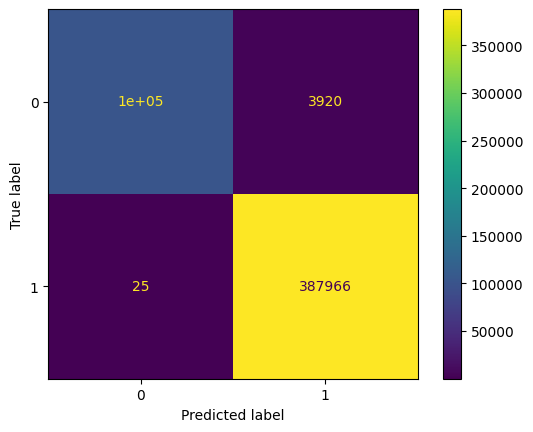

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
   y, cross_val_predictions
)


In [49]:
from sklearn.metrics import f1_score, precision_score, recall_score

f1 = f1_score(y, cross_val_predictions)
precision = precision_score(y, cross_val_predictions)
recall = recall_score(y, cross_val_predictions)

display(Markdown(f"- f1_score = {f1:.3f}\n- precision = {precision:.3f}\n- recall = {recall:.3f}"))

- f1_score = 0.995
- precision = 0.990
- recall = 1.000

The results above seem very good. Even suspiciously good. I swear that I tried to find possible leakages, but at the time of writing I could not. This is a synthetic dataset and there could be a feature that predicts surprisingly good for DDOS attacks, or there might be a bug in the code that I did not spot yet. Either way, I will take these results for good and move on.

On a different note, we see from the confusion matrix that this introduces almost 4k of false positives. This might not be very relevant in predicting DDOS attacks, however they will heavily deteriorate the performance of the overall model, which aims at detecting very rare classes.

## Limitations

It is worth noticing that `smurf` and `neptune` are not the only two exiting types of DDOS attacks. The fact that we are modelling our DDOS predictor in this way heavily impacts the ability of our model to detect and prevent other types of DDOS attacks.